In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import os
from tqdm import tqdm

/Users/raunaqrai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Load the existing filtered data
filtered_data = pd.read_csv('filtered_non_spectral_data.csv')

# Directory containing the redshift-corrected spectra files
corrected_spectra_dir = 'redshift_corrected_spectra'

# Initialize a DataFrame to hold the interpolated flux values
# This will have the same number of rows as filtered_data and a column for each interpolated point
interpolated_fluxes = pd.DataFrame(index=filtered_data.index)

filtered_data.head()

,Plate,MJD,Fiber,z,logMBH,e_logMBH,LogREdd
0,7238.0,56660.0,44.0,0.730000,8.148686,0.255619,-1.167203
1,5134.0,55868.0,129.0,0.755000,8.644306,0.274348,-1.233196
2,7038.0,56571.0,596.0,0.694000,8.345937,0.141407,-0.870526
3,6267.0,56279.0,189.0,0.739000,8.644248,0.163346,-1.325952
4,7902.0,57362.0,586.0,0.245966,8.336682,0.023865,-1.154839


In [3]:
# Wavelength range and increments for interpolation
wavelength_start = 4662.721
wavelength_end = 5062.721
increment = 1
target_wavelengths = np.arange(wavelength_start, wavelength_end, increment)

In [4]:
interpolated_flux_dict = {}

for index, row in tqdm(filtered_data.iterrows(), total=filtered_data.shape[0]):
    plate = int(row['Plate'])
    mjd = int(row['MJD'])
    fiber = int(row['Fiber'])
    filename = f'spec-{plate:04d}-{mjd:05d}-{fiber:04d}.fits'
    file_path = os.path.join(corrected_spectra_dir, filename)

    if os.path.exists(file_path):
        with fits.open(file_path) as hdul:
            data = hdul[1].data
            flux = data['flux']
            loglam = data['loglam']
            wavelength = 10**loglam

            # Interpolate the flux
            f_interp = interp1d(wavelength, flux, kind='linear', bounds_error=False, fill_value='extrapolate')
            interpolated_flux = f_interp(target_wavelengths)

            # Update the dictionary with the interpolated fluxes
            for i, wl in enumerate(target_wavelengths):
                interpolated_flux_dict[f'Flux_{wl:.1f}'] = interpolated_flux_dict.get(f'Flux_{wl:.1f}', []) + [interpolated_flux[i]]
    else:
        print(f'File {filename} not found in {corrected_spectra_dir}')
        # Fill missing values with NaN or appropriate flags when file is missing
        for wl in target_wavelengths:
            interpolated_flux_dict[f'Flux_{wl:.1f}'] = interpolated_flux_dict.get(f'Flux_{wl:.1f}', []) + [np.nan]

# Create a DataFrame from the dictionary
interpolated_fluxes = pd.DataFrame(interpolated_flux_dict)

# Combine the existing data with the interpolated flux values
all_data = pd.concat([filtered_data, interpolated_fluxes], axis=1)

# Save the combined data to a new CSV file
all_data.to_csv('all_redshifted_data.csv', index=False)

100%|███████████████████████████████████| 28837/28837 [1:26:22<00:00,  5.56it/s]


In [10]:
if 'e_logMBH' not in all_data.columns:
    # If not present, add 'e_logMBH' from 'filtered_data' to 'all_data'
    # Ensure that both DataFrames are aligned (same length and corresponding rows)
    if len(all_data) == len(filtered_data):
        # Find the index of 'logMBH' column to insert 'e_logMBH' after it
        if 'logMBH' in all_data.columns:
            loc = all_data.columns.get_loc('logMBH') + 1  # Get the position right after 'logMBH'
            all_data.insert(loc, 'e_logMBH', filtered_data['e_logMBH'])
        else:
            print("'logMBH' column not found in 'all_data'. Adding 'e_logMBH' at the end.")
            all_data['e_logMBH'] = filtered_data['e_logMBH']
    else:
        print("Data mismatch: The length of 'all_data' and 'filtered_data' are different.")
else:
    print("The column 'e_logMBH' already exists in 'all_data'.")

In [11]:
all_data.head()

,Plate,MJD,Fiber,z,logMBH,e_logMBH,LogREdd,Flux_4662.7,Flux_4663.7,Flux_4664.7,...,Flux_5052.7,Flux_5053.7,Flux_5054.7,Flux_5055.7,Flux_5056.7,Flux_5057.7,Flux_5058.7,Flux_5059.7,Flux_5060.7,Flux_5061.7
0,7238.0,56660.0,44.0,0.730000,8.148686,0.255619,-1.167203,1.343909,1.093862,0.992698,...,0.643139,0.716495,0.898708,0.894574,0.777649,0.861977,0.941514,0.864004,0.975844,1.052037
1,5134.0,55868.0,129.0,0.755000,8.644306,0.274348,-1.233196,2.569792,3.174220,2.532462,...,2.542336,2.638405,2.872202,3.053969,2.699724,2.244195,2.471145,3.049749,1.413314,1.538114
2,7038.0,56571.0,596.0,0.694000,8.345937,0.141407,-0.870526,3.249420,3.133024,2.849922,...,2.679349,2.600430,2.850586,2.506499,2.415184,2.650319,2.701523,2.629033,2.516963,2.300867
3,6267.0,56279.0,189.0,0.739000,8.644248,0.163346,-1.325952,1.807805,1.804252,1.887676,...,1.455028,1.286549,1.801417,1.662373,1.958212,1.945656,1.855846,1.926594,1.874284,1.498972
4,7902.0,57362.0,586.0,0.245966,8.336682,0.023865,-1.154839,21.722649,21.162435,21.124687,...,19.175872,19.393931,19.772522,17.300360,18.938125,19.293439,19.125158,19.157056,19.006541,18.278735


In [12]:
all_data.to_csv('all_redshifted_data.csv', index=False)

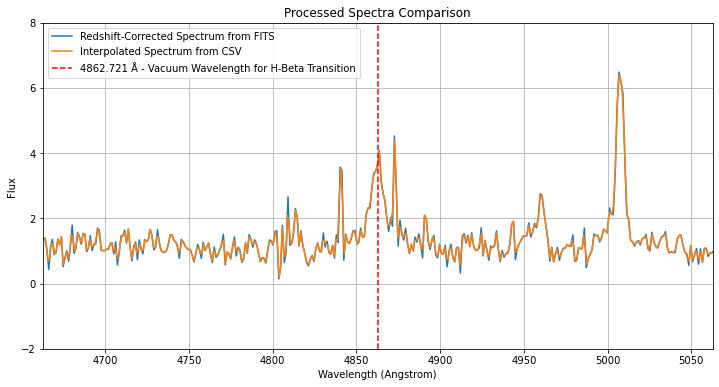

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

def plot_spectra(fits_file, csv_file, plate, mjd, fiber):
    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Load and plot data from the FITS file
    with fits.open(fits_file) as hdul:
        data = hdul[1].data
        flux = data['flux']
        loglam = data['loglam']
        wavelength = 10**loglam
        plt.plot(wavelength, flux, label='Redshift-Corrected Spectrum from FITS', zorder=1)

    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Filter the DataFrame for the corresponding row
    row = df[(df['Plate'] == plate) & (df['MJD'] == mjd) & (df['Fiber'] == fiber)]

    # Check if the row is found
    if not row.empty:
        interpolated_flux_columns = [col for col in df.columns if col.startswith('Flux_')]
        wavelengths = [float(col.split('_')[1]) for col in interpolated_flux_columns]
        interpolated_flux = row.iloc[0][interpolated_flux_columns].values
        plt.plot(wavelengths, interpolated_flux, label='Interpolated Spectrum from CSV', linestyle='-', zorder=2)

    # Set plot limits to focus on specified wavelength range
    plt.xlim(4662.7, 5062.7)
    plt.ylim(-2,8)

    # Plot details
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Processed Spectra Comparison')
    plt.axvline(x=4862.721, color='r', linestyle='--', label='4862.721 Å - Vacuum Wavelength for H-Beta Transition')
    plt.grid(True)
    plt.legend()
    plt.savefig('Interpolated Spectra Comparison')
    plt.show()

# Paths to the original and redshift-corrected spectrum files
fits_file = 'redshift_corrected_spectra/spec-3586-55181-0920.fits'  

# CSV file path
csv_file = 'all_redshifted_data.csv'

# Plate, MJD, and Fiber identifiers from the FITS file name (adjust accordingly)
plate = 3586
mjd = 55181
fiber = 920

# Plotting
plot_spectra(fits_file, csv_file, plate, mjd, fiber)
